A linear predictors is a linear function (linear combination) of a set of coefficients and explanatory variables (independent variables), whose value is used to predict the outcome of a dependent variable.

Many learning algorithms rely on linear predictors. Moreover, linear predictors are intuitive, easy to inerpret and fit the data reasonably well in many natural learning problems

Linera predictors are besd on the class of affine functions

$$ L_d = \{\mathbf x \mapsto \langle\mathbf w, \mathbf x\rangle + b:\mathbf w \in \mathbb R^d, b \in \mathbb R\} $$

Each function $h_{\mathbf w,b}$ is parametrized by a vector $\mathbf w$ that define a linear transformation and a scalar $b$ that define a translation.
Usually the term $b$, called *bias* is incorporated into $\mathbf w$ as an extra coordinate, adding also an extra coordinate with value 1 to all $\mathbf x \in \mathcal X$

$$ \mathbf w' =\begin{pmatrix}b, w_1, \ldots, w_d\end{pmatrix} \qquad \mathbf x' = \begin{pmatrix}1, x_1, \ldots, x_d\end{pmatrix}$$

## Halfspaces

A function $h_{\mathbf w,b}$ defines an hyperplane in the space $\mathbb R$ that divide this into two subsapces called *half-spaces*. The hypothesis class of halfspaces is designed for binary classification problems, namely $\mathcal X=\mathbb R^d$ and $\mathcal Y =\{-1,+1\}$. The class of half-spaces is defined as follows:

$$ HS_d = \text{sign}\circ L_d = \{\mathbf x \mapsto \text{sign}(h_{\mathbf w,b}(\mathbf x)) : h_{\mathbf w,b} \in L_d\}$$

Consider the 2-dimensional case. Each hypothesis define an hyperplane that is perpendicular to the vector $\mathbf w$ and separates the space into two sub-spaces:

- the points *above* the hyperplane (that share an acute angle with $\mathbf w$) are labeled positively
- the points *below* the hyperplane (that share an obtuse angle with $\mathbf w$) are labeled negatively

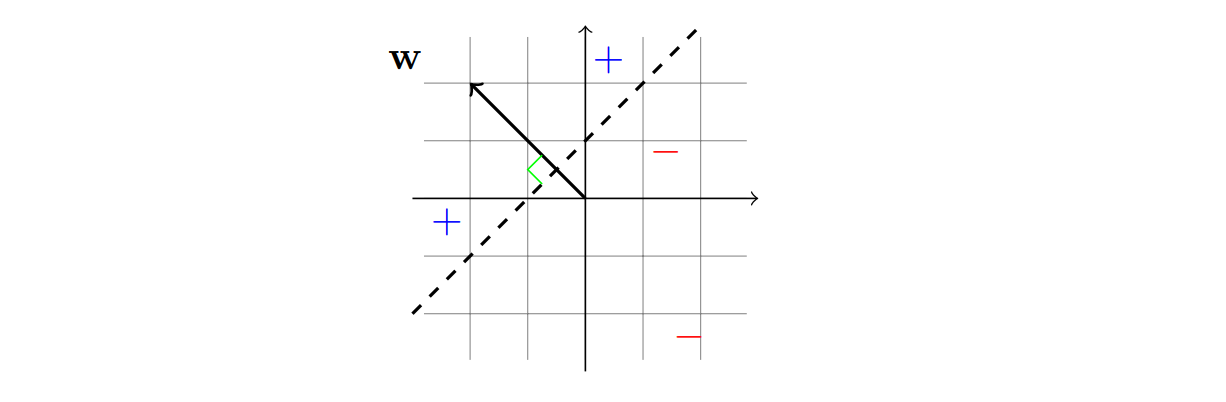

In the condition of **realizability assumption** (namely the points of the two classes are linearly separable), the ERM problem for halfspaces can be expressed as a linear program, that is an optimization problem of a *linear function* under *linear constraints*.

Let $S = \{(\mathbf x_i, y_i)\}_{i=1}^m$ be a training set of size $m$. From the realizability assumption follows that an ERM predictor should have zero errors on the training set. Or equivalently that exists at least a vector $\mathbf w^*$ such that:

$$ \text{sign}(\langle\mathbf w^*, \mathbf x_i\rangle) = y_i,\qquad \forall i = 1, \ldots, m$$

Considering the closest point to the hyperplane $\gamma = \min_i(y_i\langle\mathbf w^*, \mathbf x_i\rangle)$ we can define the vector $\mathbf{\bar w} = \frac{\mathbf w^*}{\gamma} $. Therefore foreach $i$:

$$ y_i\langle\mathbf{\bar w}, \mathbf x_i\rangle = \frac{1}{\gamma}y_i\langle\mathbf w^*, \mathbf x_i\rangle = \frac{y_i\langle\mathbf w^*, \mathbf x_i\rangle}{\min_i(y_i\langle\mathbf w^*, \mathbf x_i\rangle)} \ge 1 $$

Letting $A\in\mathbb R ^{m\times d}$ be the matrix whose elements are defined as $A_{i,j} = y_ix_{i,j}$ and letting $\mathbf v = \begin{pmatrix} 1, 1, \ldots,1\end{pmatrix}\in\mathbb R^m$, the equation above can be rewritten as a linear program:

$$ A\mathbf w \ge \mathbf v $$

Note that since all the vectors that satisfy this constraint are euqally good candidates, we can set a dummy objective $u = \begin{pmatrix} 0,0,\ldots,0\end{pmatrix}\in\mathbb R^d$

### Code implementation

We start generating the set of samples $S = \{(\mathbf x_i, y_i)\}_{i=1}^m$. In this case we will consider a simple set of 20 2D points. Remeber that we need to assure realizability assumption, namely that the points of the two classes are linearly separable, in order to make the magic happen. I have defined a separating line $y = 2*x + 5$ and then generated ten points of the class $"+"$ (above the line) and ten points of the class $"-"$ (below the line)

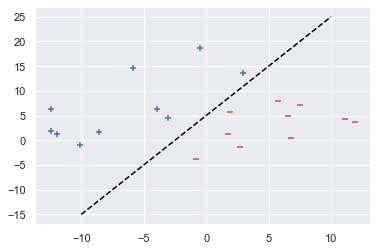

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

separating_line = lambda x: 2*x + 5

n_pos_points = 10
n_neg_points = 10

x_pos = np.array([(x - 10*np.random.rand(), separating_line(x) + 10*np.random.rand()) for x in np.random.randint(-5, 5, n_pos_points)])
x_neg = np.array([(x + 10*np.random.rand(), separating_line(x) - 10*np.random.rand())for x in np.random.randint(-5, 5, n_pos_points)])

plt.scatter(x_pos[:,0], x_pos[:,1], c='b', marker='+')
plt.scatter(x_neg[:,0], x_neg[:,1], c='r', marker='_')
plt.plot([-10,10], [separating_line(-10), separating_line(10)],  linestyle='--', color ='black')

To perform the computation of an halfspace I will make advantage of the LP library PuLP. First of all I define the set of points $X = \{\mathbf x_i = (x_{i,1}, x_{i,2})\}_{i=1}^m$ and the set of labels $y = \{y_i\}_{i=1}^m$. Then I define the dummy vector $u$ the matrix $A$ as defined above. There is no need to explicitly define the constraint vector $v$ since the constraints will be added one at a time.

In [39]:
from pulp import *  

X = np.vstack((x_pos, x_neg)) #points
y = np.hstack((np.ones(len(x_pos)), -1 * np.ones(len(x_neg)))) #labels

u = np.zeros(2)
A = X *y[:,np.newaxis]
# v = np.ones(len(X))*1.0

# Create the model
model = LpProblem(name="small-problem", sense=LpMaximize)

# Initialize the decision variables
x1 = LpVariable(name="x1", lowBound=-10)
x2 = LpVariable(name="x2", lowBound=-10)

# Adding constraints Aw > v
for i in range(len(A)):
    model += (A[i][0]*x1 + A[i][1]*x2 >= 1, f"{i}-constraints")

# model += A @ (x, y) >= [1] * len(A)
obj_func = 1.0*x1 + 1.0*x2
model += obj_func

In [34]:
model

small-problem:
MAXIMIZE
1.0*x1 + 1.0*x2 + 0.0
SUBJECT TO
0_constraints: - 10.0930607134 x1 - 0.942661104533 x2 >= 1

1_constraints: 2.9452331379 x1 + 13.6584855747 x2 >= 1

2_constraints: - 3.04716074523 x1 + 4.60978636907 x2 >= 1

3_constraints: - 3.90575356895 x1 + 6.27243438825 x2 >= 1

4_constraints: - 12.4567473723 x1 + 6.25782081058 x2 >= 1

5_constraints: - 12.4084986013 x1 + 1.88549457594 x2 >= 1

6_constraints: - 11.9172386158 x1 + 1.23096416629 x2 >= 1

7_constraints: - 8.56476139859 x1 + 1.77164508263 x2 >= 1

8_constraints: - 0.530378645166 x1 + 18.6261174828 x2 >= 1

9_constraints: - 5.86156200685 x1 + 14.554188348 x2 >= 1

10_constraints: - 11.1071614738 x1 - 4.34993451238 x2 >= 1

11_constraints: 0.796629576198 x1 + 3.75562451996 x2 >= 1

12_constraints: - 2.72470580249 x1 + 1.26053138 x2 >= 1

13_constraints: - 7.4963799505 x1 - 7.06064286477 x2 >= 1

14_constraints: - 5.76870235103 x1 - 8.00906932794 x2 >= 1

15_constraints: - 1.88155570773 x1 - 5.70850341532 x2 >= 1



In [40]:
status = model.solve()
print(f"Completed successfully: {status == 1}")

Completed successfully: True


Finally to test the results of the model, we can retrieve the computed normal vector $w$ that defines the computed separating hyperplane, compute the predicted labels as <code>np.sign(X @ w)</code> and plot the results. As we can see the model is perfectly able to find a possible separating hyperplane.

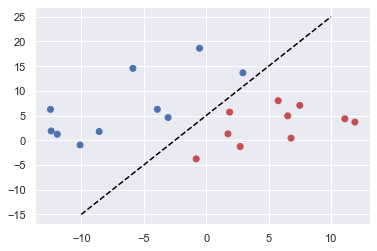

In [47]:
w = np.array([model.variables()[0].value(), model.variables()[1].value()])
y_pred = np.sign(X @ w)

colors = ['b' if y == 1.0 else 'r' for y in y_pred ]
plt.scatter(X[:,0], X[:,1], c=colors)
plt.plot([-10,10], [separating_line(-10), separating_line(10)],  linestyle='--', color ='black')